# Overview
A basic attempt at using the Tensorflow Data Pipelines combined with a pre-trained Keras model to predict tuberculosis. Specifically the code aims to replace the dated and slow Keras Image Generator with the new, fancy tf.data tools and train models in an easy, reliably manner.

### Copy
copy the weights and configurations for the pre-trained models

In [1]:
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists


In [3]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from skimage.util.montage import montage2d
from skimage.io import imread
base_dir = os.path.join('..', 'input', 'pulmonary-chest-xray-abnormalities')

## Preprocessing
Turn the HDF5 into a data-frame and a folder full of TIFF files

In [4]:
mont_paths = glob(os.path.join(base_dir, 'Montgomery', 'MontgomerySet', '*', '*.*'))
shen_paths = glob(os.path.join(base_dir, 'ChinaSet_AllFiles', 'ChinaSet_AllFiles', '*', '*.*'))
print('Montgomery Files', len(mont_paths))
print('Shenzhen Files', len(shen_paths))
all_paths_df = pd.DataFrame(dict(path = mont_paths + shen_paths))
all_paths_df['source'] = all_paths_df['path'].map(lambda x: x.split('/')[3])
all_paths_df['file_id'] = all_paths_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
all_paths_df['patient_group']  = all_paths_df['file_id'].map(lambda x: x.split('_')[0])

all_paths_df['file_ext'] = all_paths_df['path'].map(lambda x: os.path.splitext(x)[1][1:])
all_paths_df = all_paths_df[all_paths_df.file_ext.isin(['png', 'txt'])]
all_paths_df['pulm_state']  = all_paths_df['file_id'].map(lambda x: int(x.split('_')[-1]))
all_paths_df.sample(5)

Montgomery Files 277
Shenzhen Files 1325


,path,source,file_id,patient_group,file_ext,pulm_state
124,../input/pulmonary-chest-xray-abnormalities/Mo...,Montgomery,MCUCXR_0334_1,MCUCXR,txt,1
432,../input/pulmonary-chest-xray-abnormalities/Ch...,ChinaSet_AllFiles,CHNCXR_0283_0,CHNCXR,txt,0
1529,../input/pulmonary-chest-xray-abnormalities/Ch...,ChinaSet_AllFiles,CHNCXR_0069_0,CHNCXR,png,0
850,../input/pulmonary-chest-xray-abnormalities/Ch...,ChinaSet_AllFiles,CHNCXR_0065_0,CHNCXR,txt,0
739,../input/pulmonary-chest-xray-abnormalities/Ch...,ChinaSet_AllFiles,CHNCXR_0046_0,CHNCXR,txt,0


In [5]:
clean_patients_df = all_paths_df.pivot_table(index = ['patient_group', 'pulm_state', 'file_id'], 
                                             columns=['file_ext'], 
                                             values = 'path', aggfunc='first').reset_index()
clean_patients_df.sample(5)
from warnings import warn
def report_to_dict(in_path):
    with open(in_path, 'r') as f:
        all_lines = [x.strip() for x in f.read().split('\n')]
    info_dict = {}
    try:
        if "Patient's Sex" in all_lines[0]:
            info_dict['age'] = all_lines[1].split(':')[-1].strip().replace('Y', '')
            info_dict['sex'] = all_lines[0].split(':')[-1].strip()
            info_dict['report'] = ' '.join(all_lines[2:]).strip()
        else:
            info_dict['age'] = all_lines[0].split(' ')[-1].replace('yrs', '').replace('yr', '')
            info_dict['sex'] = all_lines[0].split(' ')[0].strip()
            info_dict['report'] = ' '.join(all_lines[1:]).strip()
        
        info_dict['sex'] = info_dict['sex'].upper().replace('FEMALE', 'F').replace('MALE', 'M').replace('FEMAL', 'F')[0:1]
        if 'month' in info_dict.get('age', ''):
            info_dict.pop('age') # invalid
        if 'day' in info_dict.get('age', ''):
            info_dict.pop('age') # invalid
        elif len(info_dict.get('age',''))>0:
            info_dict['age'] = float(info_dict['age'])
        else:
            info_dict.pop('age')
        return info_dict
    except Exception as e:
        print(all_lines)
        warn(str(e), RuntimeWarning)
        return {}
report_df = pd.DataFrame([dict(**report_to_dict(c_row.pop('txt')), **c_row) 
              for  _, c_row in clean_patients_df.iterrows()])
report_df.sample(5)

['male 16month', 'normal']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: 'age'


['male 16month', 'normal']
['female24yrs', 'normal']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: could not convert string to float: 'female24'


['male35yrs', 'PTB in the left upper field']
['male35yrs', 'Bilateral secondary PTB']
['Male , 38yrs,', 'secondary PTB in the bilateral upper and middle fields, mainly fibrous  lesions']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: could not convert string to float: 'male35'
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: could not convert string to float: '38,'


,age,file_id,patient_group,png,pulm_state,report,sex
139,39.0,CHNCXR_0140_0,CHNCXR,../input/pulmonary-chest-xray-abnormalities/Ch...,0,normal,F
538,38.0,CHNCXR_0539_1,CHNCXR,../input/pulmonary-chest-xray-abnormalities/Ch...,1,PTB in the left upper field,M
38,23.0,CHNCXR_0039_0,CHNCXR,../input/pulmonary-chest-xray-abnormalities/Ch...,0,normal,M
233,23.0,CHNCXR_0234_0,CHNCXR,../input/pulmonary-chest-xray-abnormalities/Ch...,0,normal,M
442,36.0,CHNCXR_0443_1,CHNCXR,../input/pulmonary-chest-xray-abnormalities/Ch...,1,right upper PTB,M


# Examine the distributions
Show how the data is distributed and why we need to balance it

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7023a0a1cdd8>,
      dtype=object)

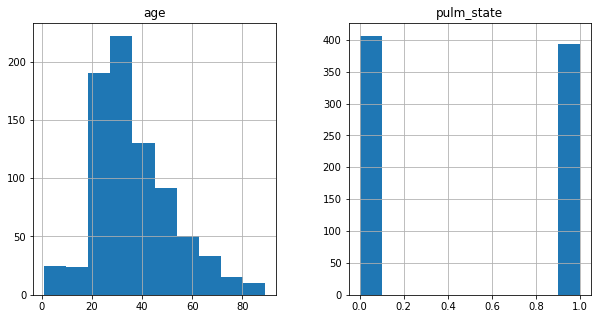

In [6]:
report_df[['age', 'patient_group', 'pulm_state', 'sex']].hist(figsize = (10, 5))

# Split Data into Training and Validation

In [7]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(report_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = report_df[['pulm_state', 'patient_group']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])
raw_train_df.sample(1)

train 600 validation 200


,age,file_id,patient_group,png,pulm_state,report,sex
725,43.0,MCUCXR_0084_0,MCUCXR,../input/pulmonary-chest-xray-abnormalities/Mo...,0,normal,F


# Balance the distribution in the training set

New Data Size: 800 Old Size: 600


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x70237cabd1d0>]],
      dtype=object)

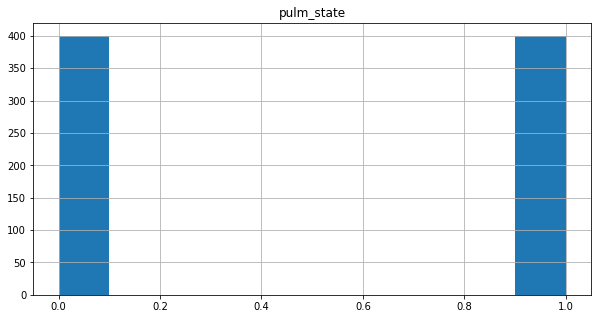

In [8]:
train_df = raw_train_df.groupby(['pulm_state', 'patient_group']).apply(lambda x: x.sample(200, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['pulm_state', 'patient_group']].hist(figsize = (10, 5))

In [12]:
import tensorflow as tf
from keras import backend as K
from keras.applications.vgg16 import preprocess_input
import numpy as np
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize_images(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.5, upper = 2.0)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (768, 768),
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 5):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            X = tf.image.resize_images(X, out_size)
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [13]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        batch_size=128, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, in_df[y_col].values))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        
        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        if batch_size>=in_len:
            yield K.get_session().run(next_batch)
        else:
            for i in range(in_len//batch_size):
                # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
                yield K.get_session().run(next_batch)

In [14]:
core_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', crop_probability=0.0) # crop doesn't work yet
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         rotation_range = 0)
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'png',
                            y_col = 'pulm_state', 
                            batch_size = 16)

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'png',
                            y_col = 'pulm_state', 
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(valid_idg, 
                               valid_df, 
                             path_col = 'png',
                            y_col = 'pulm_state', 
                             color_mode = 'rgb',
                            batch_size = valid_df.shape[0])) # one big batch

Instructions for updating:
Use the retry module or similar alternatives.


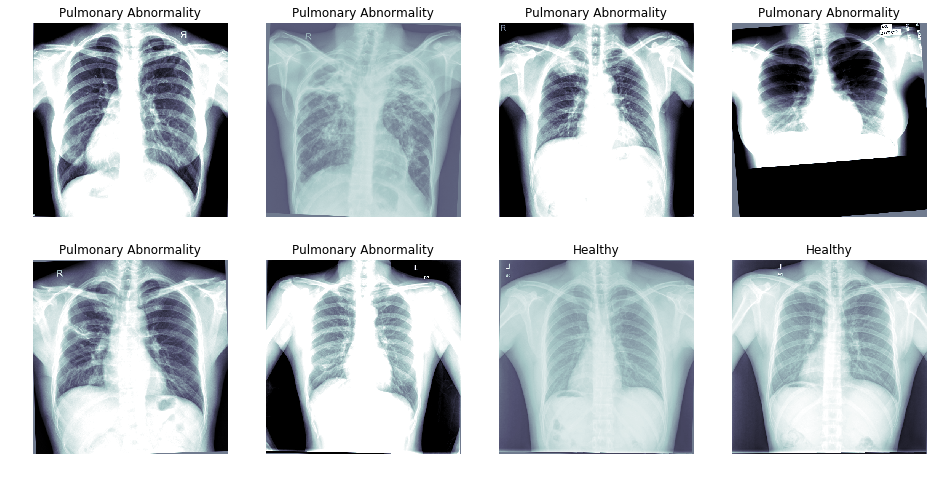

In [15]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%s' % ('Pulmonary Abnormality' if c_y>0.5 else 'Healthy'))
    c_ax.axis('off')

# Attention Model
The basic idea is that a Global Average Pooling is too simplistic since some of the regions are more relevant than others. So we build an attention mechanism to turn pixels in the GAP on an off before the pooling and then rescale (Lambda layer) the results based on the number of pixels. The model could be seen as a sort of 'global weighted average' pooling. There is probably something published about it and it is very similar to the kind of attention models used in NLP.
It is largely based on the insight that the winning solution annotated and trained a UNET model to segmenting the hand and transforming it. This seems very tedious if we could just learn attention.

In [16]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = VGG16(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'sigmoid')(dr_steps)
tb_model = Model(inputs = [in_lay], outputs = [out_layer])

tb_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy'])

tb_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 16, 16, 512)  14714688    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 512)  2048        vgg16[1][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   32832       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [17]:
!rm -rf ~/.keras # clean up the model / make space for other things

In [18]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('tb_detector')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
tb_model.fit_generator(train_gen,
                      steps_per_epoch = train_df.shape[0]//16,
                      validation_data = (test_X, test_Y), 
                      epochs = 20, 
                      callbacks = callbacks_list,
                      max_queue_size=0, 
                       workers = 0, # TF-generators are very thread-unsafe
                       use_multiprocessing=False)

Epoch 1/20
50/50 [==============================] - 1212s 24s/step - loss: 0.5204 - binary_accuracy: 0.7250 - val_loss: 0.3983 - val_binary_accuracy: 0.8750

Epoch 00001: val_loss improved from inf to 0.39834, saving model to tb_detector_weights.best.hdf5
Epoch 2/20
20/50 [===========>..................] - ETA: 11:59 - loss: 0.4378 - binary_accuracy: 0.7781

In [ ]:
# load the best version of the model
tb_model.load_weights(weight_path)
tb_model.save('full_tb_model.h5')

# Show Attention
Did our attention model learn anything useful?

In [ ]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in tb_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

In [ ]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [tb_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_label = test_Y[c_idx]
    img_ax.set_title('TB\nClass:%s' % (real_label))
    pred_confidence = tb_model.predict(cur_img)[0]
    attn_ax.set_title('Attention Map\nPred:%s' % (pred_confidence[0]))
fig.savefig('attention_map.png', dpi = 300)

# Evaluate the results
Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results. We then visualize spec

In [ ]:
pred_Y = tb_model.predict(test_X, batch_size = 16, verbose = True)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y, pred_Y>0.5))
print(classification_report(test_Y, pred_Y>0.5, target_names = ['Healthy', 'TB']))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(test_Y, pred_Y))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')